# Project 4 - Unsupervised Learning - Lautaro Cisterna


<a id="section_toc"></a> 
## Table of contents

[Sanity Check and Exploratory Data Analysis](#section_sanity_check)
- [Statistical Summary](#section_statisticalsummary)
- [Missing Value check](#section_missingvaluecheck)
- [Exploratory Data Analysis](#section_exploratorydataanalysis)
    - [Analysis for non continuous variables](#section_analysysfornoncontinousvariables)
    - [Analysis for continuos variables](#section_analysisforcontinuosvariables)
    - [Box plot for predictive features](#section_box_plot) 
    - [Bivariate Analysis - Heatmap](#section_heatmap)
    - [Pair plot](#section_pairplot)
    
    
    




[Data Preprocessing - Getting data ready for modelling](#section_gettingdataready)








[Modelling](#section_modelling)

- [1) KMeans](#section_KMeans)

- [2) Hierarchical Clustering](#section_hierarchical)





[Cluster comparison and cluster profiling](#section_comparison)

    



[Actionable Insights and Recommendations](#section_recommendations)


**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

**Loading dataset**


In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')

<a id="section_sanity_check"></a> 
# Sanity Check and Exploratory Data Analysis

In [3]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
df.shape

(660, 7)

In [5]:
df.duplicated().any() #Check duplicates in the dataset

False

We can see that all observations are different from each other.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [7]:
var_list = df.columns.tolist()
result_df = pd.DataFrame(columns = ['Variable', 'Type', 'Format'])

for i in range(len(var_list)):
    if df[var_list[i]].dtype in ['int64', 'float64']:
        var_type = 'Num.'
    else:
        var_type = 'Cat.'
    new_row = pd.Series([var_list[i], var_type, df[var_list[i]].dtype],
                       index=['Variable', 'Type', 'Format'])
    
    result_df = result_df.append(new_row, ignore_index=True)

result_df.index+=1
result_df

,Variable,Type,Format
1,Sl_No,Num.,int64
2,Customer Key,Num.,int64
3,Avg_Credit_Limit,Num.,int64
4,Total_Credit_Cards,Num.,int64
5,Total_visits_bank,Num.,int64
6,Total_visits_online,Num.,int64
7,Total_calls_made,Num.,int64


Luckily we do not have any categorical features, meaning that we won't need to transform them or something.

<a id="section_statisticalsummary"></a> 
**Statistical Summary**

In [8]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format)).T #Continuos variables

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.00,330.50,190.67,1.00,165.75,330.50,495.25,660.00
Customer Key,660.00,55141.44,25627.77,11265.00,33825.25,53874.50,77202.50,99843.00
Avg_Credit_Limit,660.00,34574.24,37625.49,3000.00,10000.00,18000.00,48000.00,200000.00
Total_Credit_Cards,660.00,4.71,2.17,1.00,3.00,5.00,6.00,10.00
Total_visits_bank,660.00,2.40,1.63,0.00,1.00,2.00,4.00,5.00
Total_visits_online,660.00,2.61,2.94,0.00,1.00,2.00,4.00,15.00
Total_calls_made,660.00,3.58,2.87,0.00,1.00,3.00,5.00,10.00


<a id="section_missingvaluecheck"></a> 
**Missing value check**

In [9]:
df.isna().sum() / df.shape[0]

Sl_No                  0.0
Customer Key           0.0
Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made       0.0
dtype: float64

Fortunately, we do not have any missing values

<a id="section_exploratorydataanalysis"></a> 
**Exploratory Data Analysis**

As we can see, the objective of this project is to identify different segments in the existing customer base, based on their spending patterns as well as past interaction with the bank. Here, EDA could help us a lot to find insights and patterns from the different segments that are going to be studied during the clustering step.

Univariate Analysis

In [10]:
df.nunique() #Number of Uniques values per col

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

<a id="section_analysysfornoncontinousvariables"></a> 
**Analysis for non continuous variables**

In [11]:
non_cont_vars = [col for col in df.columns.tolist() if df[col].nunique() < 20]
#I will consider non cont features, features that has less than 20 unique values.

In [12]:
non_cont_vars

['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

The only feature that contains more than 20 unique values is Avg_Credit_Limit. The rest have less unique values. This is considering that Sl_No and Customer_Key are not predictive feature, since they are "identification" features.

In [13]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(z):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(df[z]) # length of the column
    plt.figure(figsize=(15,5))
    ax = sns.countplot(df[z],palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.title(z)
    plt.show() # show the plot
    

                                                  Total_Credit_Cards


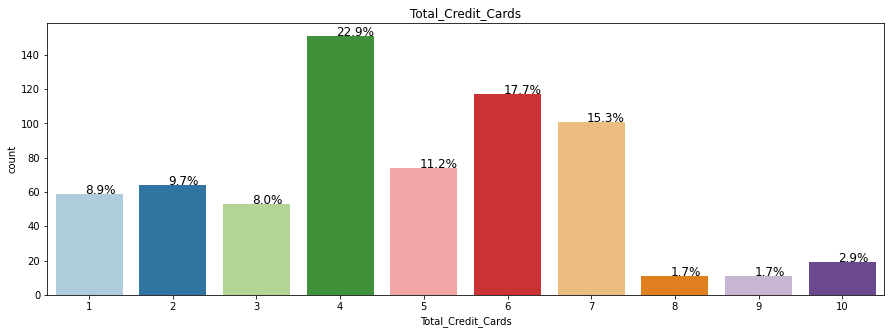

                                                  Total_visits_bank


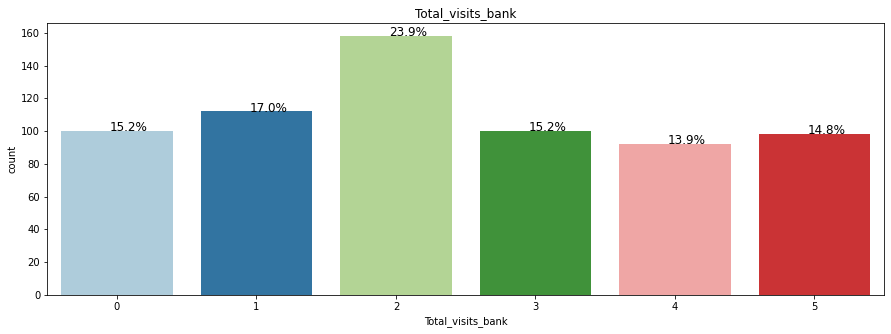

                                                  Total_visits_online


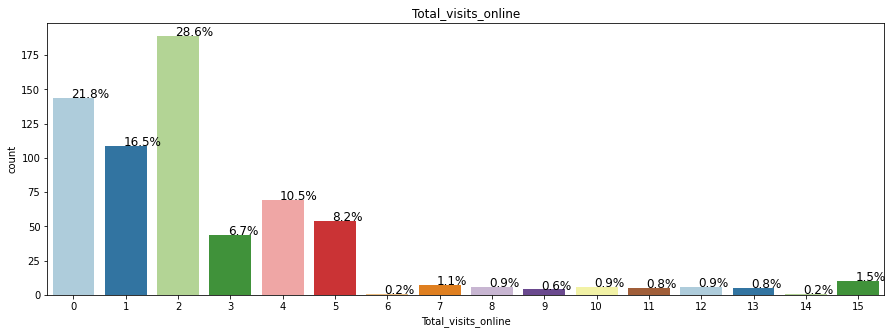

                                                  Total_calls_made


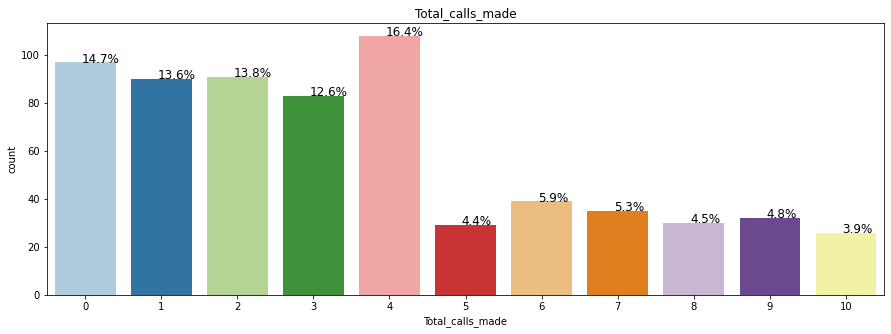

In [14]:
for var in non_cont_vars:
    print(' '*50 + '\033[1m' + var)
    perc_on_bar(var)
    print("="*115)

**Insights**

```Total_Credit_Cards```: We can see that the majority of people has between 4 cards and 7 cards. More than 50% of the observations lie within this range. Then with a few less observations, aroung 30% of it, have between 1 and 3 cards. And lastly not many people have more than 8 cards (less than 5%).

```Total_cisits_bank```: Every value from this feature has almost the same distribution, around (14% and 17%), except for value "2", which is composed by 24% of the observations. So here maybe we could say the if we want to group or segment this feature, we can create 2 groups, 2 visits to the bank vs other.

```Total_visits_online```: Even though this is not exactly a histogram, with this plot we can see that this feature is slightly skewed to the right, having some observations that lie above 5. Most of the observations fall between 0 visits to 5 visits. Having 0 and 2 as the most popular one, with 21.8% and 28.6% respectively.

```Total_calls_made```: Most of observations lie between 0 phone calls to 4 phone calls. This range contains more than 50% of the data. Than above 4 calls, the distribution of values is quite similar, between 4% and 6%.



<a id="section_analysisforcontinuosvariables"></a> 
**Analysis for continuous variables**

We have only one continuous variable, so I am going to show just a Histogram.

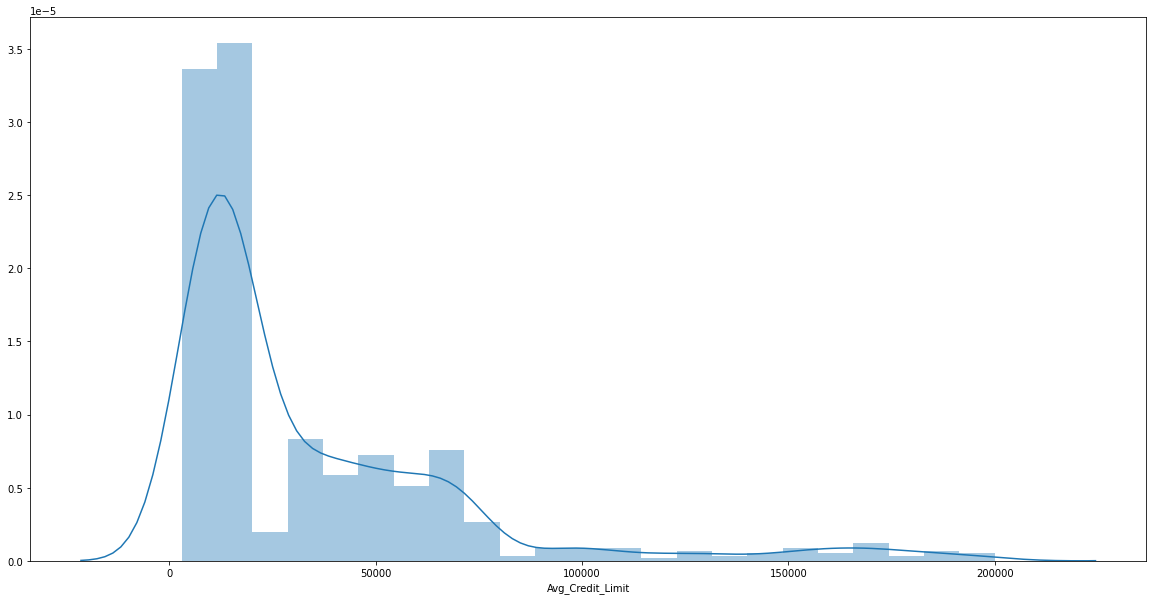

In [15]:
plt.figure(figsize=(20,10))
sns.distplot(df['Avg_Credit_Limit'])
plt.show()

We can see that this feature is right skewed, and it seems that it has two "peaks" in the distribution.

**Box plot for predictive features** <a id="section_box_plot"></a> 

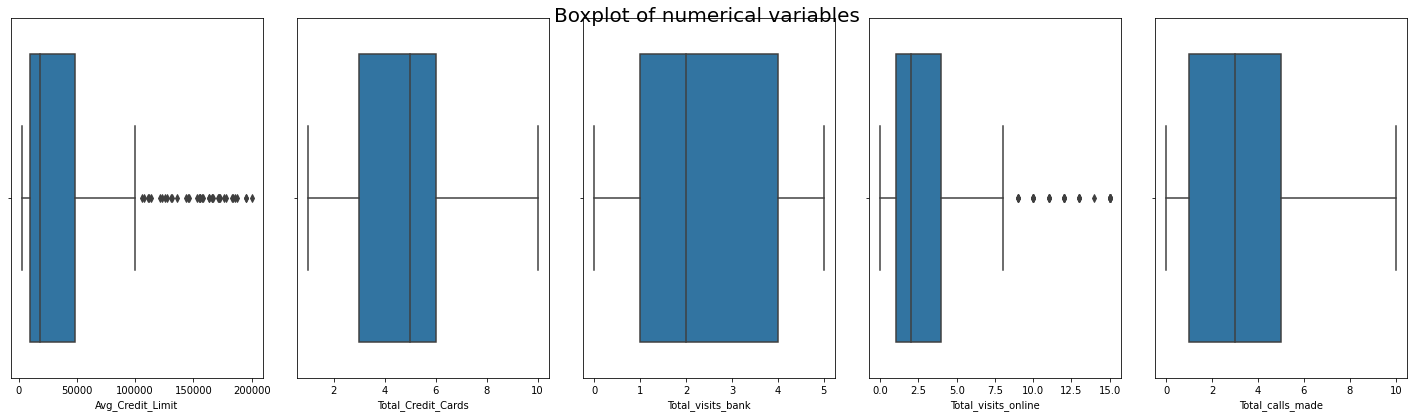

In [16]:
all_col = df.iloc[:,2:].columns.tolist()
fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

Here we can see clearly some outliers in Avg_Credit_Limit and in Total_visits_online. As I already said, these two variables were right skewed, meaning that we have a few values on the right side of the distribution.

<a id="section_heatmap"></a> 
**Bivariate Analysis**
**Correlation Matrix - Heatmap**


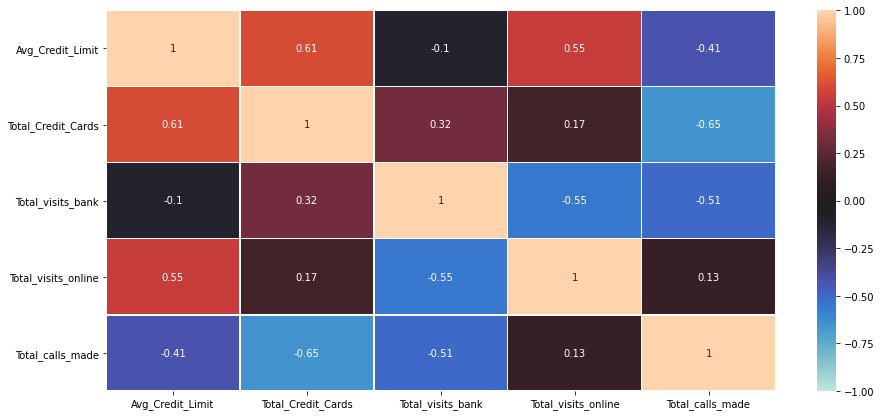

In [17]:
plt.figure(figsize=(15,7))

sns.heatmap(df[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)

plt.show()

In terms of pearson correlation, we can see that we have a positive correlation of 0.61 between Total_Credit_Cards and Avg_Credit_Limit. This makes sense since I think that the more credit cards you have, probably the more credit limit you have. As correlation does not imply causation, I cannot assure this assumption, so it's just my opinion. 

Then, we also have a high negative correlation between Total_Credit_Cards and Total_calls_made (-0.65) and between Total_visits_online and Total_visits_bank (-0.55).

<a id="section_pairplot"></a> 
**Pair plot**

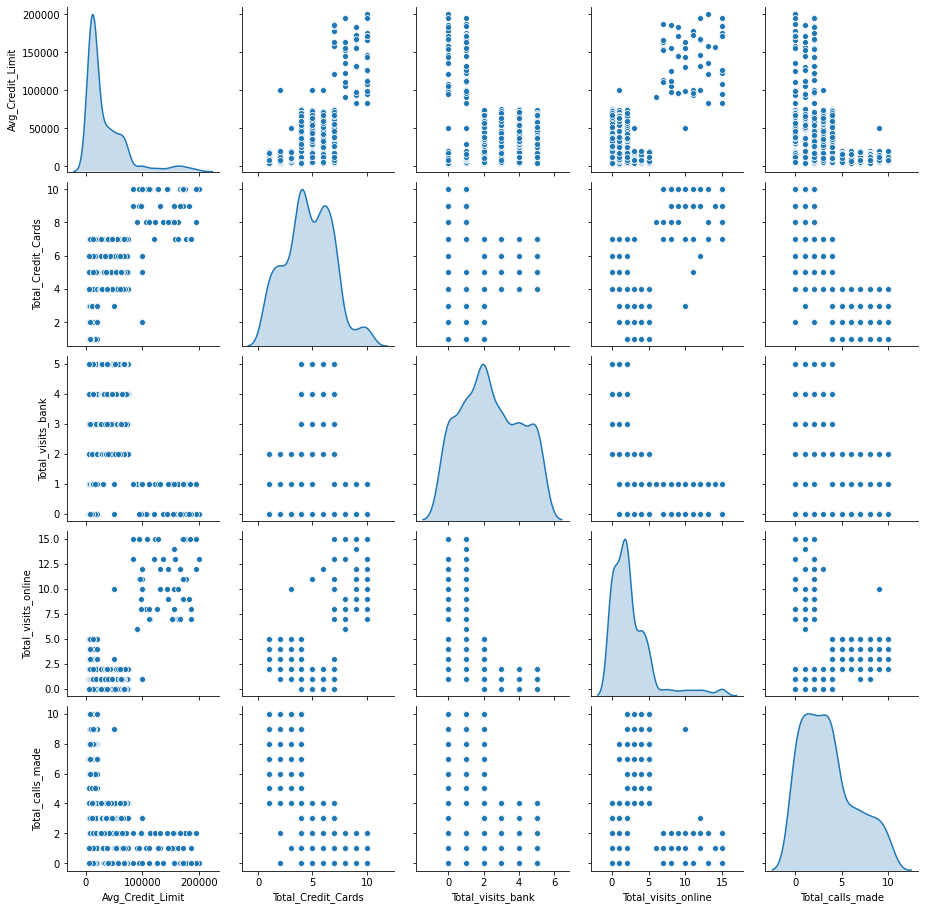

In [18]:
sns.pairplot(df[all_col],diag_kind="kde");

Even though we have already talked about univariate distributions, the density plots in the diagonal are helpful because they can "tell" us how many clusters we will probably need. For example if we see Total_Credit_Cards, we may say that two clusters will be needed.

On the other hand, the pairplots are quite usefull, because we can see bivariate behaviour between a feature against another. For example if we check the plot between Total_visits_online vs Avg_Credit_Limit, we can see clearly two clusters of points.

<a id="section_gettingdataready"></a> 
# Getting Data ready for modelling - Data Pre-processing

As we have seen, our data is entirely numerical so we do not have to do a lot of feature engineering. Also, as this is an unsupervised learning project, the main pre processing task should be scaling our data, which will be done within a pipeline. The scaling I will use is StandardScaler (zscore).

Also, we may consider outlier treatment, since KMeans is affected by them. Nevertheless, I will try two options, one is capping the outliers, and the other one is doing nothing with them. Doing nothing with them could also be helpful because we are not biasing our data.

In [19]:
X = df[all_col] #This are all my features.

**Importing transformers that are going to be inside the different pipelines**

All the pre-processing transformations are going to be in the different pipelines I will build. 

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X) #Even though I will use pipelines for scaling my data, I will create this X_scaled because it will be useful for some blocks of code.

**User defined transformer + column transformer**

Here I will create a column transformer with a user defined transformer for capping outliers. I will use the function  clip from and convert it in a transformer so I can add it to a column transformer that I will create.

I will cap the outliers to the 95th percentile.

In [24]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

def outlier_cap(data):
    return pd.DataFrame(data).apply(lambda x: x.clip(upper=x.quantile(0.95))) 
#I create the function that is going to be converted to a transformer so I can add it to a column transformer.
    

outlier_transformer = FunctionTransformer(outlier_cap) #Making the function above a transformer

#Adding the user defined transformer to my column transformer. Then I can choose to add it to the pipeline or not.
ct_outliers = make_column_transformer(
(outlier_transformer, ['Avg_Credit_Limit', 'Total_visits_online']),
remainder='passthrough')


I did not create a pipeline in this step because the last part of the pipeline will be different depending on which clustering algorithm we want to use. So probably the pipelines are going to be similar regarding transformer, but different regarding the algorithm.

**Checking this function works.**

Original histogram for Avg_Credit_Limit

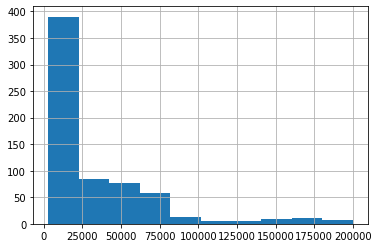

In [25]:
df['Avg_Credit_Limit'].hist()

New feature transformed applying my created transformer

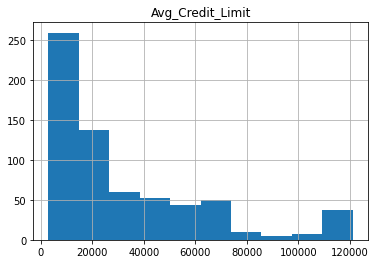

In [26]:
outlier_transformer.fit_transform(df['Avg_Credit_Limit']).hist();

We can see that we have cap the outliers to the 95th percentile, proving that the transformer works perfectly!. The same will occur with any other variable we want to cap.

<a id="section_modelling"></a>
# Modelling


<a id="section_KMeans"></a> 
# 1) KMeans 

Creating KMeans pipeline. Two pipelines will be created. One with the column transformer that contains outlier treatment, and another one without it.

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

**Analyzing KMeans with elbow method**

1) Pipeline created inside a loop where I will try different values for K. This pipeline is going to be created with no outliers treatment.

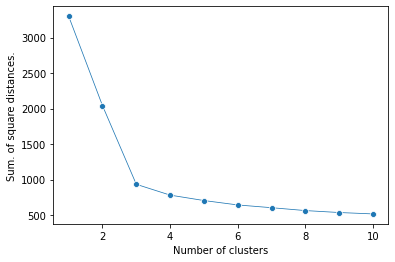

In [28]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,11)
sq_distances=[]

for k in clusters: 
    #Create a pipeline with the standard scaler and the KMeans algorithm with K
    model = make_pipeline(scaler, KMeans(n_clusters=k))
    model.fit(X)
    prediction=model.predict(X)
    sq_distances.append(model[1].inertia_)


sns.lineplot(x=clusters,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Sum. of square distances.');plt.xlabel('Number of clusters'); 


2) Pipeline created inside a loop where I will try different values for K. This pipeline is going to be created with outlier treatment.

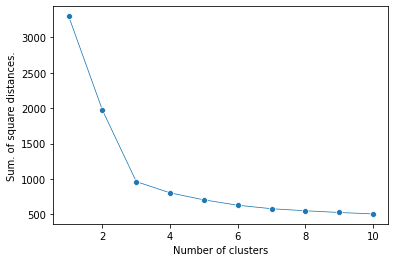

In [29]:
sq_distances=[]

for k in clusters: 
    #Create a pipeline with the column_transformers, standard scaler and the KMeans algorithm with K
    model_2 = make_pipeline(ct_outliers, scaler, KMeans(n_clusters=k))
    model_2.fit(X)
    prediction=model_2.predict(X)
    sq_distances.append(model_2[2].inertia_)


sns.lineplot(x=clusters,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Sum. of square distances.');plt.xlabel('Number of clusters');


According to the elbow method, both approaches show that the ideal amount of clusters is  K = 3. I must say that I ran the code block a few times, to see if I arrived to different results, since in every run the original centroids could have changed places. 

Since both approaches gave the same final "K", for KMeans I will continue with the 1st approach (no outlier treatment), because I rather use the original dataset.

**Silhoutte score**

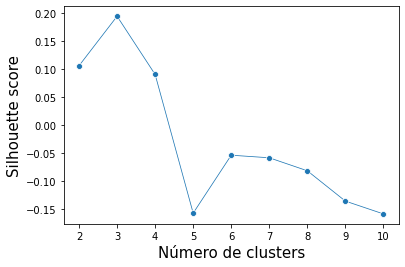

In [30]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,11);

for k in k_values:
    model = make_pipeline(scaler, KMeans(n_clusters=k)) # Numero de repeticiones=10
    model.fit(X)
    score=silhouette_score(X,model[1].labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

This plot shows us the average silohoutte score for each value of K, and again we can see that the optimal value is $k=3$. 

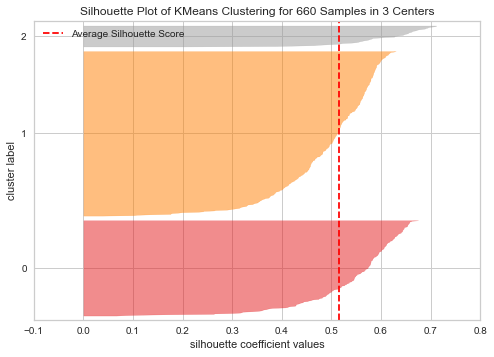

In [31]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(X_scaled)    
visualizer.show();


**Extra - Calinski Harabasz score**

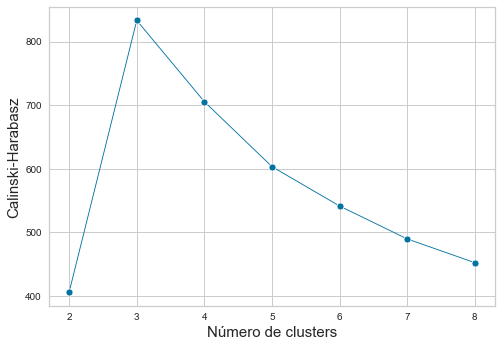

In [32]:
from sklearn.metrics import calinski_harabasz_score

k_values=range(2,9);
ch_scores=[]

for k in k_values:
    
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_scaled)
    score=calinski_harabasz_score(X_scaled,kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);


So, as we can see, K=3 is the number of clusters I will choose. I will create a column in my X data, with the label corresponding to each observation.


In [33]:
final_model=make_pipeline(scaler, KMeans(n_clusters=3, random_state=5))
final_model.fit(X)
prediction=final_model.predict(X)

#Append the prediction 
X["Cluster_KMeans"] = prediction
X.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Cluster_KMeans
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2


<a id="section_hierarchical"></a> 
# 2) Hierarchical clustering 

For hierarchical clustering, I will not use pipelines approach, because it will be easier use X_scaled directly.

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

I will create a dendogram for each linkage method. Also, I will set the parameter truncate_mode to 'lastp', so the plots are clearer.

```'lastp'```
The last p non-singleton clusters formed in the linkage are the only non-leaf nodes in the linkage; they correspond to rows Z[n-p-2:end] in Z. All other non-singleton clusters are contracted into leaf nodes. (Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)

Linkage method: single


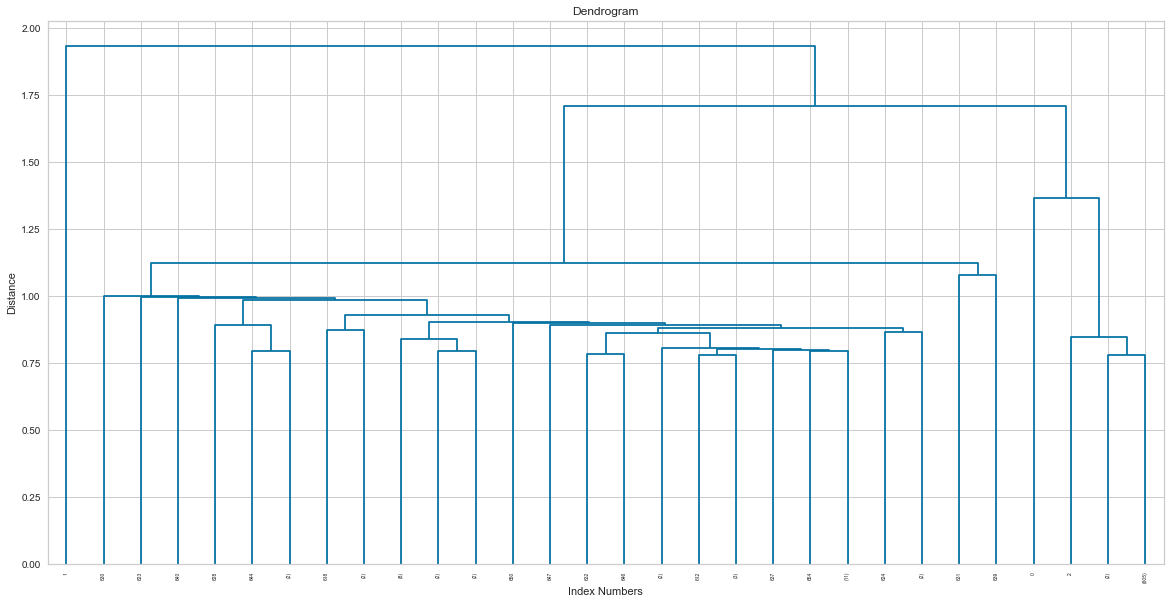

Linkage method: average


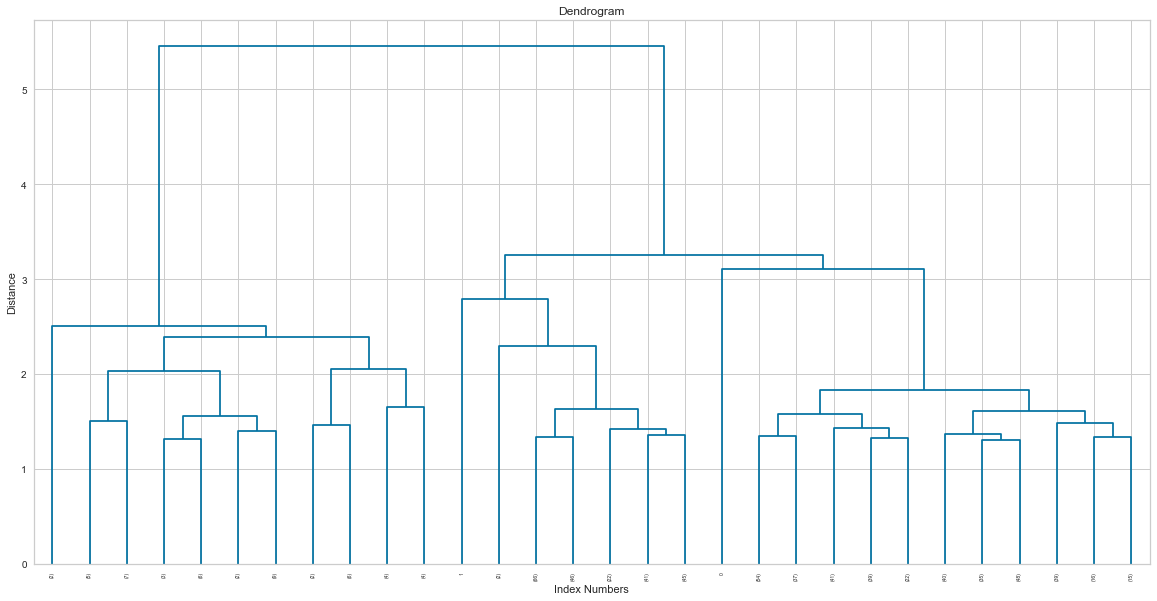

Linkage method: complete


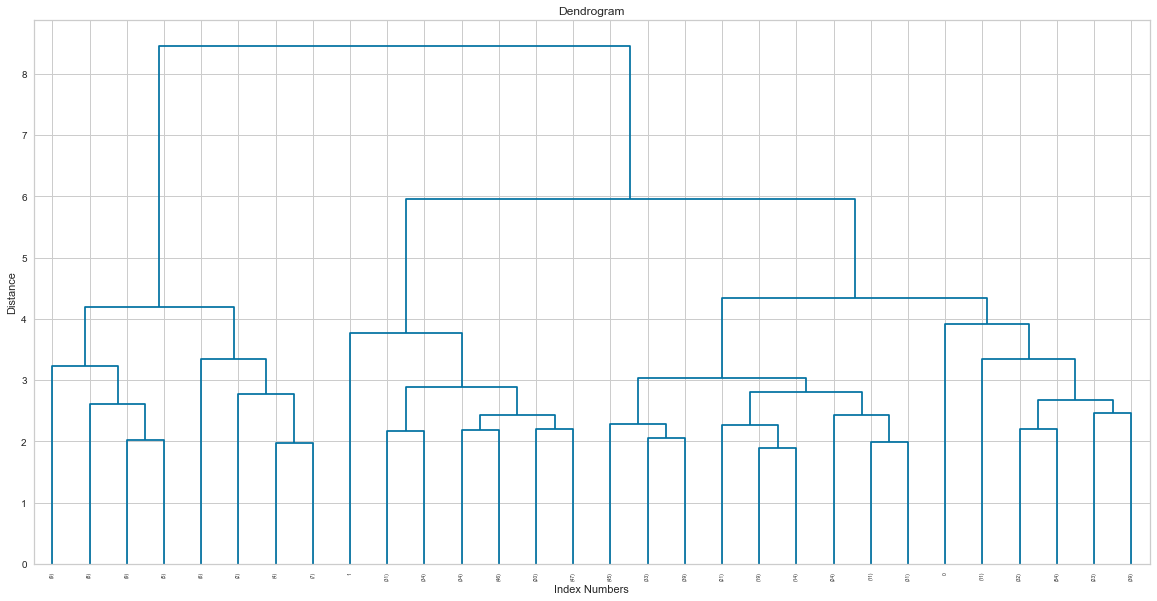

Linkage method: centroid


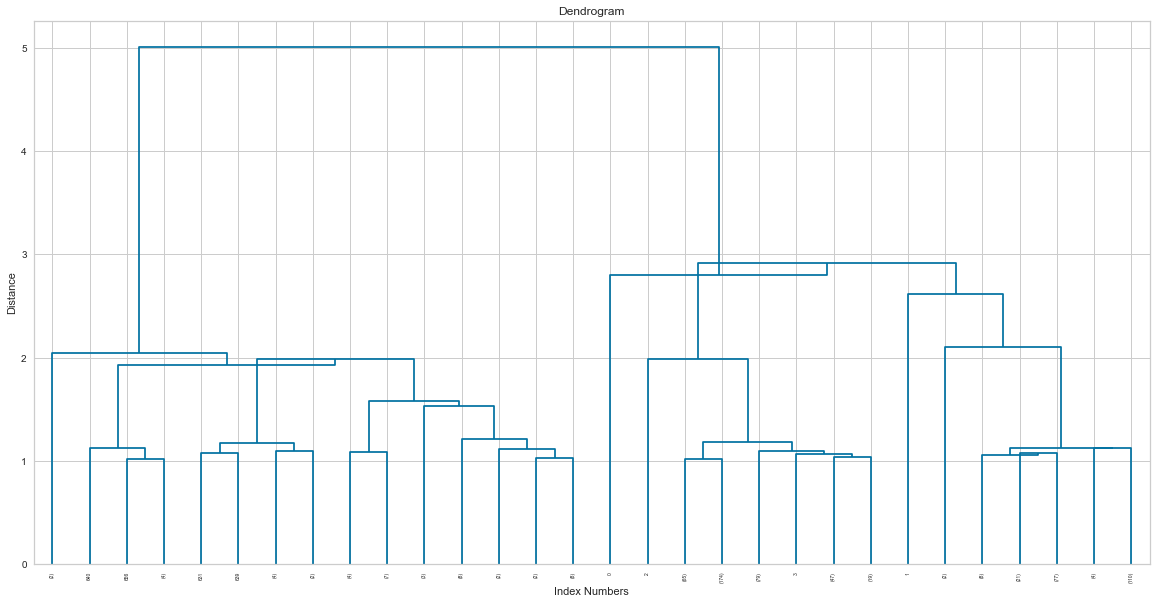

Linkage method: ward


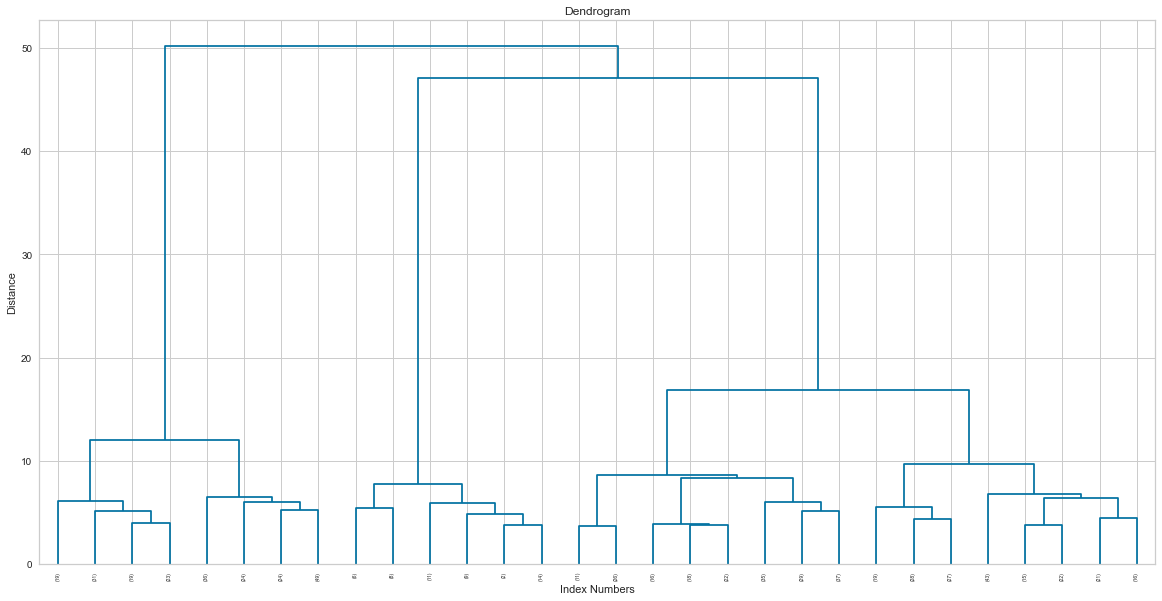

Linkage method: weighted


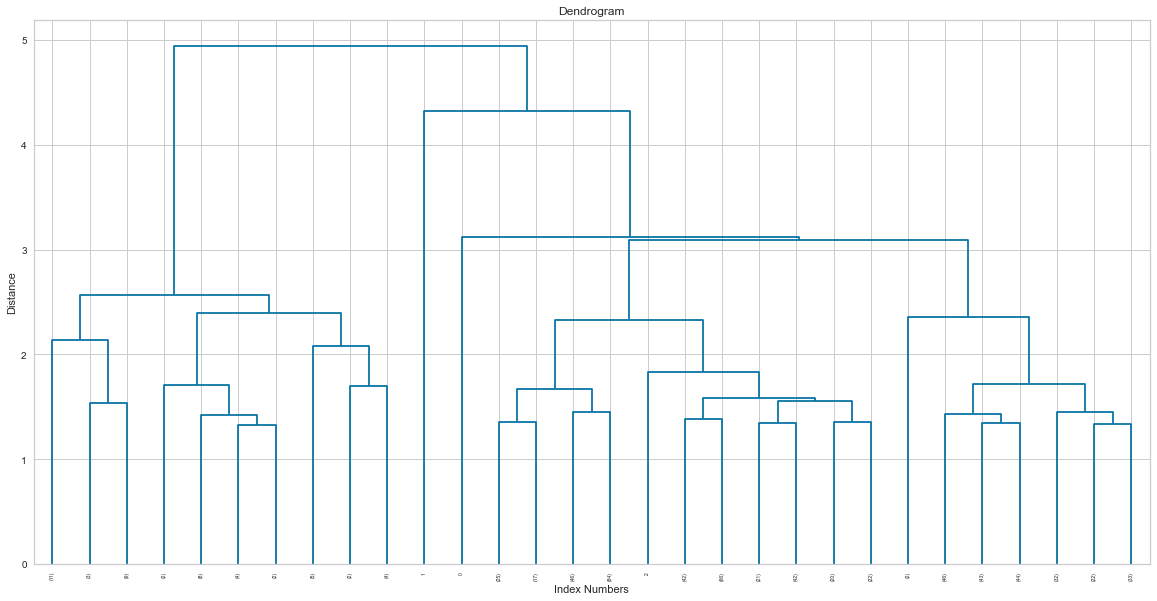

In [35]:
for link in ['single','average', 'complete', 'centroid', 'ward', 'weighted']:
    print("Linkage method: " + link)
    Z = linkage(X_scaled, link);

    plt.figure(figsize=[20,10])
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=5.,  
        color_threshold=0,
        truncate_mode='lastp' #I will truncate the observations so the plots can be clearer
    )
    plt.show()
    print("="*115)

**Insights**

I will select the linkage method "Ward", which in my opinion is the most robust of them. If we look at the ward plot, we can see that 4 clusters seems OK. Let's see the complete plot for ward and with colors.


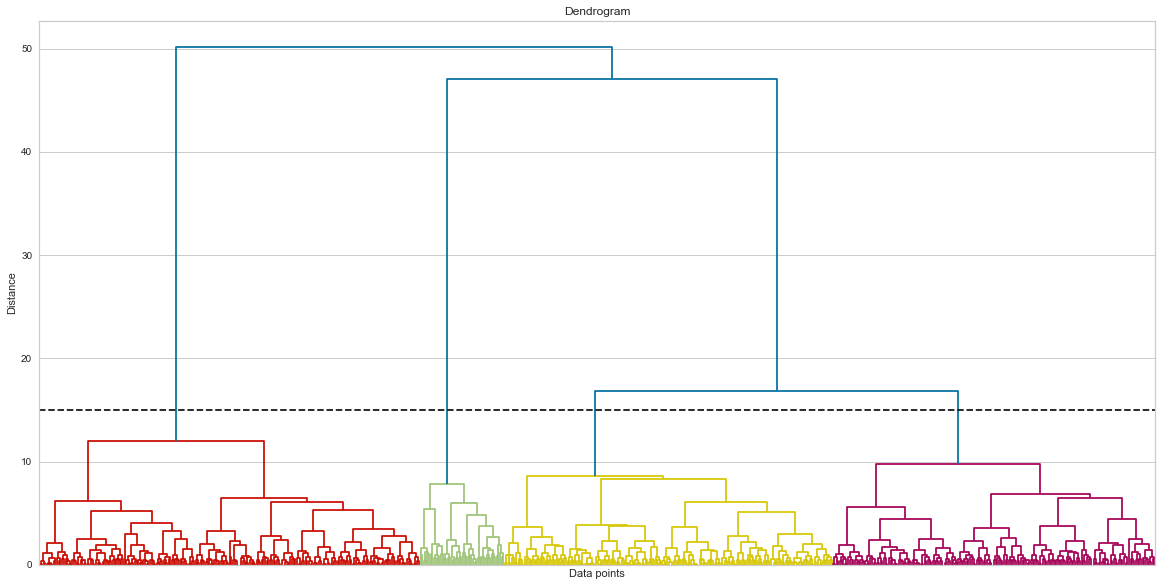

In [36]:
from scipy.cluster import hierarchy 

Z=linkage(X_scaled, "ward")

plt.figure(figsize=[20,10])
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')

color_palette=['r','g','y', 'm'];

hierarchy.set_link_color_palette(color_palette) 

dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=15
)
plt.hlines(15,0,20000,linestyle='--')
plt.xticks([])
plt.show()



**Extra - Copehenet**

I will check the Copehenet coefficient for some linkages.

In [37]:
from scipy.spatial.distance import pdist
c,dists=cophenet(Z, pdist(X_scaled))
print('Cophenetic coefficient for ward is:',c)

Cophenetic coefficient for ward is: 0.7415156284827493


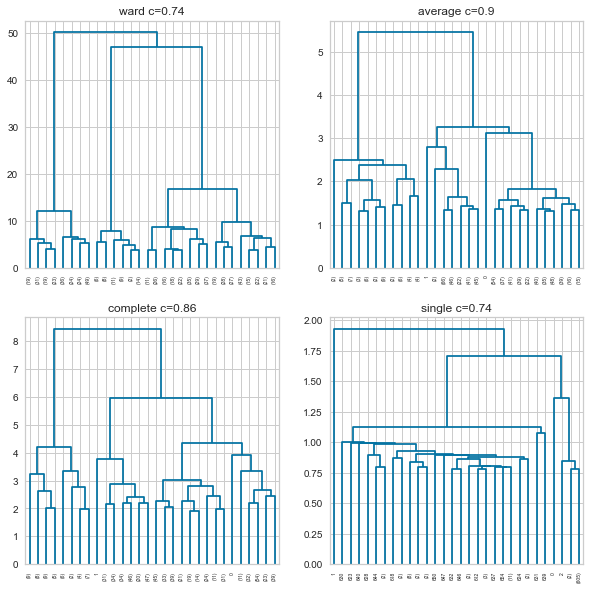

In [38]:
def plot_dendrogram(X_scaled,method,ax):
    Z = linkage(X_scaled, method);
    c,dists=cophenet(Z, pdist(X_scaled));
    ax.set_title(method+' c='+str(np.around(c,2)))        
    ax.set_xticklabels([])
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=5.,  
        color_threshold=0,
        truncate_mode='lastp',
        ax=ax
    )        
    return  



fig,axes=plt.subplots(2,2,figsize=(10,10))

plot_dendrogram(X_scaled,'ward',axes[0,0])
plot_dendrogram(X_scaled,'average',axes[0,1])
plot_dendrogram(X_scaled,'complete',axes[1,0])
plot_dendrogram(X_scaled,'single',axes[1,1])
plt.show()

In conclusion, I will create two cluster options for hierarchical clustering. The first one will be four clusters using ward linkage, and the second one will have 3 clusters using complete linkage. 

I will add two columns with this groups to the dataset so we can compare them with KMeans and with each other.

In [39]:
from sklearn.cluster import AgglomerativeClustering

In [40]:
HCmodel = AgglomerativeClustering(n_clusters=4,affinity='euclidean', linkage='ward')
HCmodel.fit(X_scaled)
X['Cluster_Hierarchical_4'] = HCmodel.labels_

In [41]:
HCmodel_2 = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='complete')
HCmodel_2.fit(X_scaled)
X['Cluster_Hierarchical_3'] = HCmodel_2.labels_

In [42]:
X.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Cluster_KMeans,Cluster_Hierarchical_4,Cluster_Hierarchical_3
0,100000,2,1,1,0,1,1,0
1,50000,3,0,10,9,0,0,2
2,50000,7,1,3,4,1,1,0
3,30000,5,1,1,4,1,1,0
4,100000,6,0,12,3,2,2,1


<a id="section_comparison"></a> 
# Cluster comparison and cluster profiling


In [43]:
#KMeans 3 clusters
cluster_profile_KMeans = X.groupby('Cluster_KMeans')[all_col].mean().reset_index().merge(
X.groupby('Cluster_KMeans')['Total_Credit_Cards'].count().reset_index().rename(columns={'Total_Credit_Cards':'N_obs'}), on="Cluster_KMeans").astype("int")

#Hierarchical 4 clusters
cluster_profile_Hierarchical_4 = X.groupby('Cluster_Hierarchical_4')[all_col].mean().reset_index().merge(
X.groupby('Cluster_Hierarchical_4')['Total_Credit_Cards'].count().reset_index().rename(columns={'Total_Credit_Cards':'N_obs'}), on="Cluster_Hierarchical_4").astype("int")

#Hierarchical 3 clusters
cluster_profile_Hierarchical_3 = X.groupby('Cluster_Hierarchical_3')[all_col].mean().reset_index().merge(
X.groupby('Cluster_Hierarchical_3')['Total_Credit_Cards'].count().reset_index().rename(columns={'Total_Credit_Cards':'N_obs'}), on="Cluster_Hierarchical_3").astype("int")

In [44]:
display(cluster_profile_KMeans.astype("int").style.highlight_max(color = 'lightgreen', axis = 0), cluster_profile_Hierarchical_4.astype("int").style.highlight_max(color = 'lightgreen', axis = 0), 
        cluster_profile_Hierarchical_3.astype("int").style.highlight_max(color = 'lightgreen', axis = 0))



,Cluster_KMeans,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,N_obs
0,0,12174,2,0,3,6,224
1,1,33782,5,3,0,2,386
2,2,141040,8,0,10,1,50


,Cluster_Hierarchical_4,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,N_obs
0,0,12151,2,0,3,6,225
1,1,38298,5,2,0,2,191
2,2,141040,8,0,10,1,50
3,3,29474,5,4,1,1,194


,Cluster_Hierarchical_3,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,N_obs
0,0,33151,5,3,1,2,397
1,1,141040,8,0,10,1,50
2,2,12234,2,0,3,7,213


**Note**
We can see that manu clusters are similar or almost the same, but they have different labels. This is why I will create a new fature in those tables, with the cluster "Name" so is easier to compare.

Also, this number could change, since I did not use random_state in every run.

In [45]:
cluster_profile_KMeans['Cluster_name'] = ["A", "B", "C"]
cluster_profile_Hierarchical_4['Cluster_name'] = ["A", "B", "C", "D"]
cluster_profile_Hierarchical_3['Cluster_name'] = ["B", "C", "A"]


display(cluster_profile_KMeans.style.highlight_max(color = 'lightgreen', axis = 0), cluster_profile_Hierarchical_4.style.highlight_max(color = 'lightgreen', axis = 0), 
        cluster_profile_Hierarchical_3.style.highlight_max(color = 'lightgreen', axis = 0))



,Cluster_KMeans,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,N_obs,Cluster_name
0,0,12174,2,0,3,6,224,A
1,1,33782,5,3,0,2,386,B
2,2,141040,8,0,10,1,50,C


,Cluster_Hierarchical_4,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,N_obs,Cluster_name
0,0,12151,2,0,3,6,225,A
1,1,38298,5,2,0,2,191,B
2,2,141040,8,0,10,1,50,C
3,3,29474,5,4,1,1,194,D


,Cluster_Hierarchical_3,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,N_obs,Cluster_name
0,0,33151,5,3,1,2,397,B
1,1,141040,8,0,10,1,50,C
2,2,12234,2,0,3,7,213,A


Now if we look at the column Cluster_name we have a more clear view of the clusters and it will be easier to compare them.

**Clusters Comparison**

First I will compare KMeans and Hierarchical_3 (3 clusters), since both have 3 clusters. We can see that these two approaches are very similar. If we analyze the average values for each column per cluster, we can see that the differences are not significant at all. The same occurs when we compare the number of observations per cluster.
For example, cluster "C" in KMeans has a Average credit limit of 141.040, 9 Credit cards, 0 bank visits, 10 online visits, 1 call made and is composed by 50 observations. On the other side, if we look at cluster "C" in Hierarchical_3, we can see that the values are exactly the same. 
With the other two clusters we have a similar scenario. Even though the values are not exactly the same, they are very close.

Then, if we compare any of the approaches with 3 clusters vs Hierarchical_4 (4 clusters), we can see that again we have some similar results. For example Cluster A is very similar among the three approaches. The same occurs with sample C, among all the approaches, that clusters are very similar. The difference is regarding cluster B. For Kmeans and Hier_3 we have similar values, but in Hier_4, this cluster is divided in B and D, since we have one more cluster.

**Insights**

For analyzing the insights and the profiles of each cluster, I will consider the KMeans approach (3 clusters). Also, a boxplot per cluster will be plotted below.

Analyzing this approach, we have 3 clusters. Cluster A, or cluster 0 for KMeans, is the cluster that have observations with the lowest Avg_Credit limit. It is composed by 224 observatons (34% of the data), and it is also the cluster with the lowest average regarding Total_Credit_Cards (which makes sense since the credit limit avg is also low). One interesting fact about this cluster, is that is the one with the highest mean regarding calls made. Regarding phone_calls, it makes sense, since the bank is calling these people so they can acquire more products.

On the other hand, we have cluster B, which is the most "populated" cluster, with 386 observations (58%). This cluster contains people with an avg_credit_limit of 33.782 (middle ground), 5 credit cards, 3 bank visits, and only two calls made. 

Lastly, we have cluster C. This cluster is composed only by 50 observations (7.5% of the data). This cluster probably contains some extreme values (we saw some of them in the EDA, specially in Avg_Credit_Limit and Total_visits_online), meaninig that the algorithm was able to detect this observations and grouped them together. This cluster also is the one with the highest Credit cards per observation, meaning that people from this cluster could have a regular interaction with the bank, using its products regularly.

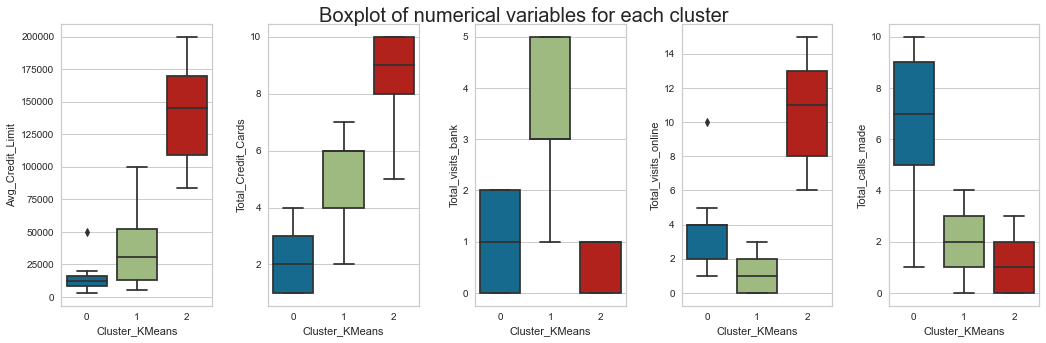

In [410]:
fig, axes = plt.subplots(1, 5,  figsize=(15, 5))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=X[all_col[counter]],x=X['Cluster_KMeans'])
    counter = counter+1

fig.tight_layout(pad=2.0)

<a id="section_recommendations"></a> 
# Actionable Insights & Recommendations




Many of the actionable insights and recomendations were already mentioned in the previous section. 

If I have to advice the bank, I will recommend the bank to focus more on clusters A and C, since cluster C contains clients that seems to have regular interaction with the bank. Nevertheless, the bank should not forget about this clients, maybe they can promote some promotions or benefits for them, so they stay the same or better.

As I already say, I will focus more on clusters A and B. Regarding cluster A, we can see that people from this group do not have many credit cards, and their interactions with the bank is not that good. Maybe the bank can offer more products to these clients, or take some action so they can be more proactive. Of course we should consider the risk of this, because maybe this clients have low credit limit and less credit cards because they are considered as "risky" clients. If this is the case, the marketing department should work along with the risk area, so as not to make mistakes and loose money by giving credit to people who is not willing to pay.

Lastly, I may say that cluster B is the "average" cluster, containing most of the clients of the sample. Maybe the bank could focus on this clients by trying to find the "best" customers in terms of credit risk, and offer more products to them.